In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Imports

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

from psutil._common import bytes2human
import time
import sys
import numpy as np
import scipy as sp
import torch as tc
# import skdim
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from hummingbird.ml import convert
from scipy.integrate import solve_ivp, odeint
import scipy.signal as signal
import pypsr as pyps
import re
from datetime import datetime
from tqdm.notebook import tqdm, trange
import gzip
import os
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from matplotlib import rc
%matplotlib inline

from numba import jit
from fast_histogram import histogram2d

np.set_printoptions(linewidth=250)

font_dir = 'C:/Users/AdamG/Anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/'
# font_dir = '/Users/adamgiammarese/Library/Fonts/'

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Set Directories

In [3]:
base_dir = base_dir = os.getcwd().replace('\\','/') + '/'

fig_dir = base_dir + 'Figures/Logistic Map/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

data_dir = base_dir + 'Logistic_Data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

os.chdir(base_dir)

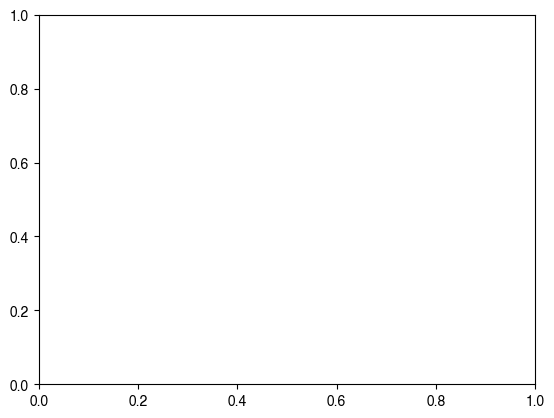

In [4]:
# !cp Helvetica.ttf $font_dir

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}')


plt.rcParams['savefig.bbox'] = 'tight'

import matplotlib.font_manager as fm
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
font = {'fontname':'Helvetica'}

# Helper Functions

In [5]:
tc.backends.cuda.is_built(), tc.backends.cudnn.is_available()

(True, True)

In [6]:
def logistic(x,r=3.57):
    return r*x*(1-x)

def evolve(f,n,x0,r=3.57):
    x = [x0]
    for i in range(1,n):
        x += [f(x[i-1],r)]
    return np.array(x)

def lead_data(data,stride=1,lead=1):
    n_samples = len(data) - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j,:].flatten()
        labels[i,:] = data[j+lead,:].flatten()
    return features, labels

def make_features_and_labels(data,k,xi=1,stride=1,lead=1):
    n_samples = len(data) - (k-1)*xi - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,k*n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j:j+k*xi:xi,:].T.flatten()
        labels[i,:] = data[j+(k-1)*xi+lead,:].flatten()
    return features, labels

def feature_selection(features, labels, n_estimators=100, max_depth=None,
                      random_state=None, n_jobs=-1, n_samples=None,
                      model_type='RFR', verbose=False):
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    start_time = time.time()
    stride = 1 if n_samples is None else len(features)//n_samples
    if model_type == 'RFR':
        Regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs, verbose=verbose).fit(features[::stride],
                                                                                                   labels[::stride])
    else:
        Regressor = ExtraTreesRegressor(n_estimators=n_estimators, random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs, verbose=verbose).fit(features[::stride],
                                                                                                 labels[::stride])
    end_time = time.time()
    if verbose:
        print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
        print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(Regressor))))
    return Regressor.feature_importances_, end_time-start_time

def future_prediction(features, labels, FIs, future, p=None, xi=1,
                      n_estimators=200, disp_progress=False, desc='',
                      max_depth=None, random_state=None, n_jobs=-1,
                      min_samples_split=2, min_samples_leaf=1, ccp_alpha=0,
                      max_features=1.0, n_samples=None, model=None, s=None,
                      model_type='RFR', verbose=False, model_conversion=None,
                      device='cuda'):
    N = np.shape(labels)[1]
    k = np.shape(FIs)[0]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if p is None:
        p = len(np.where(FIs >= np.mean(FIs))[0])
        if verbose or disp_progress:
            print(f'Num features selected: {p} of {len(FIs)}')
    elif type(p) != int:
        p = round(p*len(FIs))
    else:
        if p < 0:
            p = len(FIs)
    ind = np.argsort(-FIs)[:p]
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
            #         elif model_type == 'GBR':
            #             model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth, verbose=True)
            #         elif model_type == 'HGBR':
            #             model = HistGradientBoostingRegressor(max_iter=n_estimators, random_state=random_state, verbose=True)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])

        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))


    prediction = np.zeros((future,N))
    if s is None:
        s = features[-1].reshape((N,k*xi)) # shape (N, k*xi)
    else:
        s = s.reshape((N,k*xi)) # shape k*xi
    #     s_delayed = s[:,::xi] # length k
    s_delayed = s[:,-(k-1)*xi-1::xi]

    if disp_progress:
        lst = trange(future,desc=desc)
    else:
        lst = range(future)
    for i in lst:
        y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
        prediction[i,:] = y_pred.reshape(-1,)
        s = np.hstack((s.reshape((N,k*xi))[:,1:],y_pred))
        #         s_delayed = s[:,::xi]
        s_delayed = s[:,-(k-1)*xi-1::xi]
    prediction = np.array(prediction)
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def future_prediction_lead(features, labels, FIs, future, lead=1, p=None, xi=1, n_estimators=200,
                           disp_progress=False, desc='', leave=False, max_depth=None, random_state=None,
                           n_jobs=-1, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0, max_features=1.0,
                           n_samples=None, model=None, y_train=None, y_test=None, model_type='RFR', verbose=False,
                           open_loop=True):
    N = np.shape(labels)[1]
    k = np.shape(FIs)[0]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if p is None:
        p = len(np.where(FIs >= np.mean(FIs))[0])
        if verbose:
            print(f'Num features selected: {p} of {len(FIs)}')
    elif type(p) != int:
        p = round(p*len(FIs))
    else:
        if p < 0:
            p = len(FIs)
    ind = np.argsort(-FIs)[:p]
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
    
    
    if open_loop:
#         prediction = np.zeros((future,N))

        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed_open_loop = np.zeros((future,p))
        for i in range(future):
            s_delayed_open_loop[i,:] = s[:,::xi].flatten()[ind]
            if i >= lead - 1:
                s = np.hstack((s.flatten()[1:],y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s.flatten()[1:],y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            
        prediction = model.predict(s_delayed_open_loop).reshape(-1,1)
#         print(s_delayed_open_loop.shape,s_delayed_open_loop[0,:].reshape(1, -1).shape)
#         print(model.predict(s_delayed_open_loop).shape, model.predict(s_delayed_open_loop[0,:].reshape(1, -1))[0].reshape((N,1)).shape)
#         prediction = np.zeros((future,N))
#         for i in range(future):
#             prediction[i,:] = model.predict(s_delayed_open_loop[i,:].reshape(1, -1))[0].reshape((N,1))
    else:
        prediction = np.zeros((future,N))

        # s = y_train[-k*xi-lead+1:len(y_train)-(lead-1)].T.flatten().reshape((N,k*xi))
        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        # s_delayed = s[:,-(k-1)*xi-lead::xi]
        s_delayed = s[:,::xi]
        
        if disp_progress:
            lst = trange(future,desc=desc,leave=leave)
        else:
            lst = range(future)
        for i in lst:
            y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
            prediction[i,:] = y_pred
            if i >= lead - 1:
                s = np.hstack((s.flatten()[1:],y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s.flatten()[1:],y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            # s_delayed = s[:,-(k-1)*xi-1::xi]
            s_delayed = s[:,::xi]
            
    prediction = np.array(prediction)
#     print(prediction.shape)
        
    end_time = time.time()
    if verbose:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def rmse(x,y,z,x_result,y_result,z_result,cutoff=0,rm_transient=0):
    x_diff_sq = np.power(x[cutoff+rm_transient:] - x_result[cutoff:],2)
    y_diff_sq = np.power(y[cutoff+rm_transient:] - y_result[cutoff:],2)
    z_diff_sq = np.power(z[cutoff+rm_transient:] - z_result[cutoff:],2)
    return np.sqrt((x_diff_sq + y_diff_sq + z_diff_sq)/3)

def rmse_vec(y_test,y_pred):
    return np.sqrt(np.mean(np.vstack([(y_test[:,i]-y_pred[:,i])**2 for i in range(y_test.shape[1])]), axis=0))

def envelope_length(y_test,y_pred,threshold=5):
    error_signal = rmse_vec(y_test,y_pred)
    return np.argmax(error_signal > threshold)

def lyapunov_time(t,LE_max,cutoff=0,rm_transient=0):
    return (t[cutoff+rm_transient:]-t[cutoff+rm_transient])/LE_max

def get_left_bin_edge(val,bin_edges):
    for i in range(len(bin_edges)):
        if bin_edges[i] > val:
            break
    return bin_edges[i-1], i-1

def get_bottom_height(current_rects,hist,index,scaling=1):
    bottom = current_rects[index]
    height = 1#/hist[index]
    return bottom*scaling, height*scaling

def add_rect_to_plot(left,bottom,width,height,color,ax=None,alpha=1,zorder=None):
    if zorder is None:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)#,facecolor=color)
    else:
        rect=mpatches.Rectangle((left,bottom),width,height,fill=True,zorder=zorder,
                            facecolor=color,linewidth=0,edgecolor=color,alpha=alpha)
    if ax is None:
        plt.gca().add_patch(rect)
    else:
        ax.add_patch(rect)

def delay_embedding_multidimensional(data, emb_dim, n=None, tau=1):
    # input is shape (n_dims,n_samples)
    data = np.array(data)
    if n is None:
        n = data.shape[1] - (emb_dim-1)*tau
    embedding = np.zeros((n,emb_dim*len(data)))
    for i in range(n):
        j = i
        embedding[i,:] = data[:,j:j+emb_dim*tau:tau].flatten()
    return embedding

def RMSE_summary(y_pred, y_test):
    return np.sqrt(np.mean((y_pred-y_test)**2))

def PCC_summary(y_pred, y_test):
    o_dev = y_test - np.mean(y_test)
    p_dev = y_pred - np.mean(y_pred)
    return np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2)))

def get_hausdorff_dimension_data(data, num=40, lims=(0.01, 50), remove_pval=0):
    if lims is None:
        dist_mat = euclidean_distances(data, data)
#         lims = np.min(dist_mat[np.triu_indices(len(dist_mat), 1)]), np.max(dist_mat)
        lims = (np.min(dist_mat[np.nonzero(dist_mat)]),
                min([(np.max(data[:,i])-np.min(data[:,i])) for i in range(data.shape[1])])) #np.max(dist_mat)
        del dist_mat
    lin_lims = np.log(lims)
#     lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0]/2,
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]/2])
    lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0],
                   lin_lims[1]])
#     lims = np.exp([lin_lims[0],
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]])
    return _get_hausdorff_dimension_data(data, num, lims)

# @jit(nopython=False, parallel=True, nogil=False)
def _get_hausdorff_dimension_data(data, num, lims):
    scales = np.geomspace(lims[0], lims[1], num=num)
    ranges = [(np.min(data[:,i]), np.max(data[:,i])) for i in range(data.shape[1])]
    Ns = np.zeros((num))
    for i, scale in enumerate(scales):
#         if data.shape[1] == 2:
#             H = histogram2d(data[:,0], data[:,1], [round((ranges[i][1]-ranges[i][0])/scale) for i in range(2)],
#                             ranges)
#         else:
        H, _ = np.histogramdd(data, bins=[np.arange(ranges[i][0],ranges[i][1],scale) for i in range(data.shape[1])])
        Ns[i] = np.sum(H>0)
        
    return scales[Ns>0], Ns[Ns>0]

def hausdorff_dimension(data, num=40, lims=None, remove_pval=0, mode='highest_r2', param=10, debug_plots=False, debug_data=False):
    scales, Ns = get_hausdorff_dimension_data(data, num, lims, remove_pval)
    scales_log = np.log(scales)
    Ns_log = np.log(Ns)
    
    if mode == 'highest_slope' or mode == 'highest_r2' or mode == 'highest_product':
        def subarrays(n, x):
            return np.fromfunction(lambda i, j: x[i + j], (len(x) - n + 1, n), 
                                   dtype=int)
        
        if type(param) == int:
            min_pts = param
        else:
            min_pts = round(param*num)

        indices = np.arange(len(Ns))
        windows = []
        for i, window_length in enumerate(range(min_pts, len(Ns))):
            windows += subarrays(window_length, indices).tolist()

        slopes, r2_values = np.zeros((len(windows),)), np.zeros((len(windows),))
        for i, window in enumerate(windows):
            slope, _, r_value, _, _ = sp.stats.linregress(scales_log[window], Ns_log[window])
            slopes[i], r2_values[i] = slope, r_value**2
        
        if mode == 'highest_slope':
            i = np.argmax(np.abs(slopes))
        elif mode == 'highest_r2':
            i = np.argmax(r2_values)
        else:
            i = np.argmax(np.abs(slopes)*r2_values)
            
        start_ind, end_ind = windows[i][0], windows[i][-1]
    else:
        thresh = param
        diff2 = np.gradient(np.gradient(np.log(Ns)))

        linear_inds = np.where(np.logical_and(diff2 >= -thresh, diff2 <= thresh))[0]
        jump_inds = np.where(np.diff(linear_inds) > 1)[0]
        jump_inds = np.unique(np.hstack(([0],jump_inds,[len(linear_inds)-1])))
        ind_maxjump = np.argmax(np.diff(jump_inds))
        start_ind, end_ind = jump_inds[ind_maxjump:ind_maxjump+2]
        start_ind += 1
        start_ind, end_ind = linear_inds[[start_ind, end_ind]]
#         jumps = np.where(np.diff(linear_inds) > 1)[0]
#         linear_widths = np.diff(np.hstack(([0],jumps)))
#         start_ind, end_ind = linear_inds[0], np.where(np.diff(linear_inds) > 1)[0][0]
    

    coeffs = np.polyfit(scales_log[start_ind:end_ind],
                        Ns_log[start_ind:end_ind],deg=1)
    poly = np.poly1d(coeffs)
    yfit = np.exp(poly(scales_log[start_ind:end_ind]))


    if debug_plots:
        fontsize = 24
        lw = 2

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)


        fig, axs = plt.subplots(2,1,figsize=(10,12),height_ratios=(1,2))
        ax1, ax2 = axs

        if mode == 'highest_slope' or mode == 'highest_r2' or mode == 'highest_product':
            window_lens = [len(window) for window in windows]
            
            scatter = ax1.scatter(r2_values, slopes, s=5, c=window_lens)
            ax1.plot(r2_values[i], slopes[i], 'ro', ms=10)
            
            ax1.set_xlabel(r'R$^2$ Values', fontsize=fontsize)
            ax1.set_ylabel(r'Slopes', fontsize=fontsize)
            
            cbar = plt.colorbar(scatter, ax=ax1, location='top')
            cbar.set_label('Window Length', fontsize=fontsize)
        else:
            ax1.plot(np.arange(num), diff2, 'k', lw=2)
            ax1.plot(np.arange(start_ind, end_ind), diff2[start_ind:end_ind], 'o', c='orange', ms=10, mew=2, mfc='none')
            ax1.axhline(0, c='k', ls='--', lw=lw)
            ax1.axhline(thresh, c='k', ls=':', lw=lw/2)
            ax1.axhline(-thresh, c='k', ls=':', lw=lw/2)
            ax1.fill_between([0,len(diff2)], -thresh, thresh, color='k', alpha=0.1)

            ax1.set_xlim(0,len(diff2))

            ax1.set_xlabel('Index', fontsize=fontsize)
            ax1.set_ylabel('Second Derivative', fontsize=fontsize)

        ax2.plot(scales_log, Ns_log,'ko',ms=8)

        ax2.plot(scales_log[start_ind:end_ind],Ns_log[start_ind:end_ind],'o',ms=8,color='red')


        yfit = np.exp(poly(scales_log))
        ax2.plot(scales_log, np.log(yfit),lw=2,color='red')
        ax2.set_xlabel(r'$\log(\epsilon)$', fontsize=fontsize)
        ax2.set_ylabel(r'$\log(N(\epsilon))$', fontsize=fontsize)
        
        xlim = ax2.get_xlim()
        ylim = ax2.get_ylim()
        loc = np.array([np.mean([scales_log[start_ind], scales_log[end_ind]]),
                       poly(np.mean([scales_log[start_ind], scales_log[end_ind]]))])
#         loc = np.array((xlim[0] + 0.45*(xlim[1]-xlim[0]), poly(np.mean(xlim))))
        angle = np.degrees(np.arctan2(np.diff(poly(xlim)), np.diff(xlim)))
        trans_angle = ax2.transData.transform_angles(angle,
                                                     loc.reshape((1, 2)))[0]
        ax2.text(loc[0]+.01*(xlim[1]-xlim[0]), loc[1]+.01*(ylim[0]-ylim[0]),
                 fr'Slope $={coeffs[0]:.5f}$', fontsize=fontsize, rotation=trans_angle,
                 color='red', ha='center', va='bottom', rotation_mode='anchor')
        
        
        
        plt.show()

    if debug_data:
        return -coeffs[0], scales, Ns
    else:
        return -coeffs[0]

def get_correlation_dimension_data(data, num=40, lims=(0.01, 50), remove_pval=0):
    dist_mat = euclidean_distances(data, data)
    if lims is None:
#         lims = np.min(dist_mat[np.triu_indices(len(dist_mat), 1)]), np.max(dist_mat)
        lims = np.min(dist_mat[np.nonzero(dist_mat)]), np.max(dist_mat)
    lin_lims = np.log(lims)
#     lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0]/2,
#                    lin_lims[1]-remove_pval*np.diff(lin_lims)[0]/2])
    lims = np.exp([lin_lims[0]+remove_pval*np.diff(lin_lims)[0],
                   lin_lims[1]])
    return _get_correlation_dimension_data(dist_mat, num, lims)

@jit(nopython=True, parallel=True, nogil=True)
def _get_correlation_dimension_data(dist_mat, num, lims):
    n1 = len(dist_mat)
    
    eps_l = np.geomspace(lims[0], lims[1], num=num)
    C_eps_l = np.zeros((num))
    for i, eps in enumerate(eps_l):
        a = np.less(dist_mat, eps)
        np.fill_diagonal(a, 0)
        C_eps_l[i] = np.sum(a)/float(n1**2)
        
    return eps_l, C_eps_l

def correlation_dimension(data, num=40, lims=None, remove_pval=0, mode='highest_r2', param=10, debug_plots=False, debug_data=False):
    eps_l, C_eps_l = get_correlation_dimension_data(data, num, lims, remove_pval)
    eps_l_log = np.log(eps_l)
    C_eps_l_log = np.log(C_eps_l)
    
    if mode == 'highest_slope' or mode == 'highest_r2':
        def subarrays(n, x):
            return np.fromfunction(lambda i, j: x[i + j], (len(x) - n + 1, n), 
                                   dtype=int)
        
        if type(param) == int:
            min_pts = param
        else:
            min_pts = round(param*num)

        indices = np.arange(len(C_eps_l))
        windows = []
        for i, window_length in enumerate(range(min_pts, len(C_eps_l))):
            windows += subarrays(window_length, indices).tolist()

        slopes, r2_values = np.zeros((len(windows),)), np.zeros((len(windows),))
        for i, window in enumerate(windows):
            slope, _, r_value, _, _ = sp.stats.linregress(eps_l_log[window], C_eps_l_log[window])
            slopes[i], r2_values[i] = slope, r_value**2
        
        if mode == 'highest_slope':
            i = np.argmax(slopes)
        else:
            i = np.argmax(r2_values)
            
        start_ind, end_ind = windows[i][0], windows[i][-1]
    else:
        thresh = param
        diff2 = np.gradient(np.gradient(np.log(C_eps_l)))

        linear_inds = np.where(np.logical_and(diff2 >= -thresh, diff2 <= thresh))[0]
        jump_inds = np.where(np.diff(linear_inds) > 1)[0]
        jump_inds = np.unique(np.hstack(([0],jump_inds,[len(linear_inds)-1])))
        ind_maxjump = np.argmax(np.diff(jump_inds))
        start_ind, end_ind = jump_inds[ind_maxjump:ind_maxjump+2]
        start_ind += 1
        start_ind, end_ind = linear_inds[[start_ind, end_ind]]
#         jumps = np.where(np.diff(linear_inds) > 1)[0]
#         linear_widths = np.diff(np.hstack(([0],jumps)))
#         start_ind, end_ind = linear_inds[0], np.where(np.diff(linear_inds) > 1)[0][0]
    

    coeffs = np.polyfit(eps_l_log[start_ind:end_ind],
                        C_eps_l_log[start_ind:end_ind],deg=1)
    poly = np.poly1d(coeffs)
    yfit = np.exp(poly(eps_l_log[start_ind:end_ind]))


    if debug_plots:
        fontsize = 24
        lw = 2

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)


        fig, axs = plt.subplots(2,1,figsize=(10,12),height_ratios=(1,2))
        ax1, ax2 = axs

        if mode == 'highest_slope' or mode == 'highest_r2':
            window_lens = [len(window) for window in windows]
            
            scatter = ax1.scatter(r2_values, slopes, s=5, c=window_lens)
            ax1.plot(r2_values[i], slopes[i], 'ro', ms=10)
            
            ax1.set_xlabel(r'R$^2$ Values', fontsize=fontsize)
            ax1.set_ylabel(r'Slopes', fontsize=fontsize)
            
            cbar = plt.colorbar(scatter, ax=ax1, location='top')
            cbar.set_label('Window Length', fontsize=fontsize)
        else:
            ax1.plot(np.arange(num), diff2, 'k', lw=2)
            ax1.plot(np.arange(start_ind, end_ind), diff2[start_ind:end_ind], 'o', c='orange', ms=10, mew=2, mfc='none')
            ax1.axhline(0, c='k', ls='--', lw=lw)
            ax1.axhline(thresh, c='k', ls=':', lw=lw/2)
            ax1.axhline(-thresh, c='k', ls=':', lw=lw/2)
            ax1.fill_between([0,len(diff2)], -thresh, thresh, color='k', alpha=0.1)

            ax1.set_xlim(0,len(diff2))

            ax1.set_xlabel('Index', fontsize=fontsize)
            ax1.set_ylabel('Second Derivative', fontsize=fontsize)

        ax2.plot(eps_l_log, C_eps_l_log,'ko',ms=8)

        ax2.plot(eps_l_log[start_ind:end_ind],C_eps_l_log[start_ind:end_ind],'o',ms=8,color='red')


        yfit = np.exp(poly(eps_l_log))
        ax2.plot(eps_l_log, np.log(yfit),lw=2,color='red')
        ax2.set_xlabel(r'$\log(\epsilon)$', fontsize=fontsize)
        ax2.set_ylabel(r'$\log(C(\epsilon))$', fontsize=fontsize)
        
        xlim = ax2.get_xlim()
        ylim = ax2.get_ylim()
        loc = np.array([np.mean([eps_l_log[start_ind], eps_l_log[end_ind]]),
                       poly(np.mean([eps_l_log[start_ind], eps_l_log[end_ind]]))])
#         loc = np.array((xlim[0] + 0.45*(xlim[1]-xlim[0]), poly(np.mean(xlim))))
        angle = np.degrees(np.arctan2(np.diff(poly(xlim)), np.diff(xlim)))
        trans_angle = ax2.transData.transform_angles(angle,
                                                     loc.reshape((1, 2)))[0]
        ax2.text(loc[0]-.01*(xlim[1]-xlim[0]), loc[1]+.01*(ylim[0]-ylim[0]),
                 fr'Slope $={coeffs[0]:.5f}$', fontsize=fontsize, rotation=trans_angle,
                 color='red', ha='center', va='bottom', rotation_mode='anchor')
        
        
        
        plt.show()

    if debug_data:
        return coeffs[0], eps_l, C_eps_l
    else:
        return coeffs[0]

# Recreating Dynamics

In [95]:
rs = [0.5, 2, 3.2, 3.5, 3.56, 3.6, 3.7, 3.8, 3.9]

x0 = 0.25 # initial x value
n_train = 2000
n_test = 1000
rm_transient = 10
k = 20
xi = 1

pred_results, test_results = [], []

for r in tqdm(rs):
    print(f'r={r}: -----------------------------------------------------------------')
    x = evolve(logistic,rm_transient + n_train + n_test + 2, x0, r=r)
    x = x.reshape(-1,1)
    
    X_train, y_train = lead_data(x[rm_transient:rm_transient+n_train+1,:])
    X_test, y_test = lead_data(x[rm_transient+n_train+1:,:])
    
    features, labels = make_features_and_labels(X_train, k, xi=xi, stride=1, lead=1)
    
    FIs, time_elapsed = feature_selection(features, labels, n_estimators=100, max_depth=None, random_state=None,
                                          n_jobs=-1, n_samples=None, model_type='ETR', verbose=True)
    
    s = None#y_train[-k*xi:len(y_train)].T.flatten()
    y_pred_TreeDOX, model, time_elapsed = future_prediction(features, labels, FIs,
                                                            len(y_test), p=None, xi=xi,
                                                            n_estimators=200,
                                                            disp_progress=True,
                                                            desc='',
                                                            max_depth=None,
                                                            random_state=None,
                                                            n_jobs=-1,
                                                            min_samples_split=2,
                                                            min_samples_leaf=1,
                                                            ccp_alpha=0,
                                                            max_features=0.5,
                                                            n_samples=None,
                                                            model=None, s=s,
                                                            model_type='ETR',
                                                            verbose=False,
                                                            model_conversion=None,
                                                            device='cuda')
    
    pred_results += [y_pred_TreeDOX]
    test_results += [y_test]
    print('------------------------------------------------------------------------\n\n\n')

  0%|          | 0/9 [00:00<?, ?it/s]

r=0.5: -----------------------------------------------------------------
Training time: 00 hours, 00 minutes, 00.092499 seconds
RAM Used: 31.0K
Num features selected: 20 of 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training time: 00 hours, 00 minutes, 00.171501 seconds
RAM Used: 59.4K


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 36.967500 seconds
------------------------------------------------------------------------



r=2: -----------------------------------------------------------------
Training time: 00 hours, 00 minutes, 00.087500 seconds
RAM Used: 31.0K
Num features selected: 20 of 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training time: 00 hours, 00 minutes, 00.168000 seconds
RAM Used: 59.4K


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 36.600001 seconds
------------------------------------------------------------------------



r=3.2: -----------------------------------------------------------------
Training time: 00 hours, 00 minutes, 00.097500 seconds
RAM Used: 45.1K
Num features selected: 8 of 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training time: 00 hours, 00 minutes, 00.190000 seconds
RAM Used: 87.5K


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 36.132503 seconds
------------------------------------------------------------------------



r=3.5: -----------------------------------------------------------------
Training time: 00 hours, 00 minutes, 00.110998 seconds
RAM Used: 172.2K
Num features selected: 9 of 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training time: 00 hours, 00 minutes, 00.193498 seconds
RAM Used: 318.6K


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 36.269498 seconds
------------------------------------------------------------------------



r=3.56: -----------------------------------------------------------------
Training time: 00 hours, 00 minutes, 00.117001 seconds
RAM Used: 1.3M
Num features selected: 9 of 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


Training time: 00 hours, 00 minutes, 00.202498 seconds
RAM Used: 2.6M


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 35.492998 seconds
------------------------------------------------------------------------



r=3.6: -----------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training time: 00 hours, 00 minutes, 00.233502 seconds
RAM Used: 27.2M
Num features selected: 8 of 20
Training time: 00 hours, 00 minutes, 00.265002 seconds
RAM Used: 54.4M


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 35.919498 seconds
------------------------------------------------------------------------



r=3.7: -----------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training time: 00 hours, 00 minutes, 00.229997 seconds
RAM Used: 27.2M
Num features selected: 3 of 20
Training time: 00 hours, 00 minutes, 00.239002 seconds
RAM Used: 54.4M


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 35.505997 seconds
------------------------------------------------------------------------



r=3.8: -----------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training time: 00 hours, 00 minutes, 00.228000 seconds
RAM Used: 27.2M
Num features selected: 3 of 20
Training time: 00 hours, 00 minutes, 00.231497 seconds
RAM Used: 54.4M


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 35.508497 seconds
------------------------------------------------------------------------



r=3.9: -----------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


Training time: 00 hours, 00 minutes, 00.227500 seconds
RAM Used: 27.2M
Num features selected: 3 of 20
Training time: 00 hours, 00 minutes, 00.231999 seconds
RAM Used: 54.4M


  0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 00 hours, 00 minutes, 35.759499 seconds
------------------------------------------------------------------------





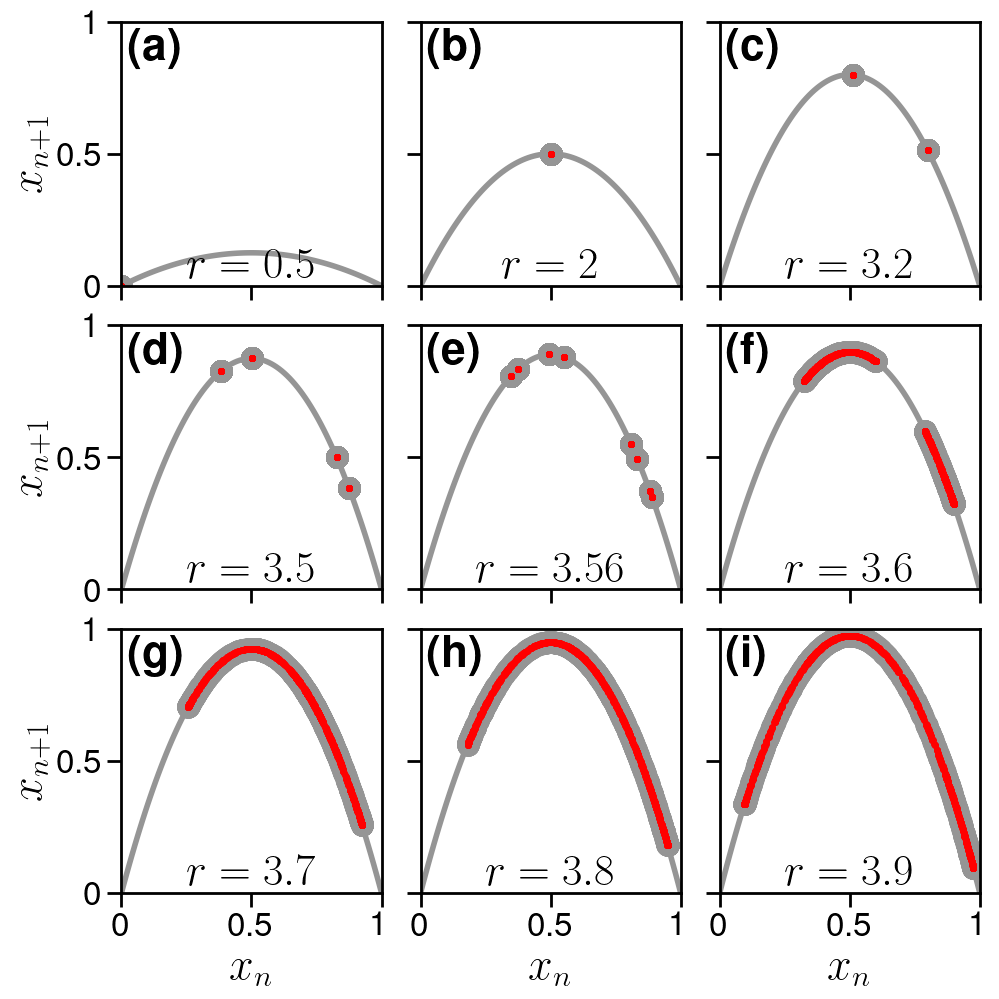

In [96]:
fig, axs = plt.subplots(3,3,sharex=True,sharey=True,figsize=(10,10))

fontsize = 32

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

lw = 4
ms = 15
ms_pred = 4

plt.xlim([0,1])
plt.ylim([0,1])

axs = axs.flatten()


for i in range(len(rs)):
    ax = axs[i]
    y_test = test_results[i]
    y_pred = pred_results[i]

#     ax.grid()

    if i in [0,3,6]:
        ax.set_ylabel('$x_{n+1}$',fontsize=fontsize,fontproperties=prop)

    if i in [6,7,8]:
        ax.set_xlabel('$x_n$',fontsize=fontsize)

    lab = [0,0.5,1]
    ax.set_xticks(lab)
    ax.set_yticks(lab)
    ax.set_xticklabels([str(i) for i in lab])
    ax.set_yticklabels([str(i) for i in lab])


#     if i == 0 or i == 3:
#         ax.set_yticks([0.2,0.4,0.6,0.8,1])
#     elif i == 6:
#         ax.set_yticks([0,0.2,0.4,0.6,0.8])
#     elif i == 7:
#         ax.set_xticks([0.2,0.4,0.6,0.8])

    x_plt = np.linspace(0,1,100)
    ax.plot(x_plt,rs[i]*x_plt*(1-x_plt),c=np.array([1,1,1])*150/256,lw=lw)

    ax.plot(y_test[:-1],y_test[1:],'o',c=np.array([1,1,1])*150/256,ms=ms)
    ax.plot(y_pred[:-1],y_pred[1:],'ro',ms=ms_pred)

#     ax.text(0.025,0.91,r'$r='+str(rs[i])+r'$',fontsize=fontsize)
    # ax.text(0.5,0.025,r'$r='+str(rs[i])+r'$',ha='center',fontsize=fontsize)
    ax.annotate(r'$r='+str(rs[i])+r'$',xy=(0.5,0.025),ha='center',fontsize=fontsize,fontproperties=prop)



# plt.supxlabel('$x_n$',fontsize=18)
# plt.supylabel('$x_{n+1}$',fontsize=18)
plt.tight_layout()
plt.subplots_adjust(hspace=0.15,wspace=0.15)
fig.align_labels([axs])

for i in range(len(rs)):
    plt.setp(axs[i].spines.values(), linewidth=2)
    axs[i].tick_params(length=10,width=2)
    axs[i].annotate(r'\textbf{('+chr(97+i)+')}', xy=(0.025,0.975), ha='left', va='top', fontsize=fontsize)


# plt.subplots_adjust(wspace=0.1, hspace=0.1)

# plt.title('Logistic Map Bifurcation',fontsize=18)
title = 'Logistic Map Recreated Dynamics'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

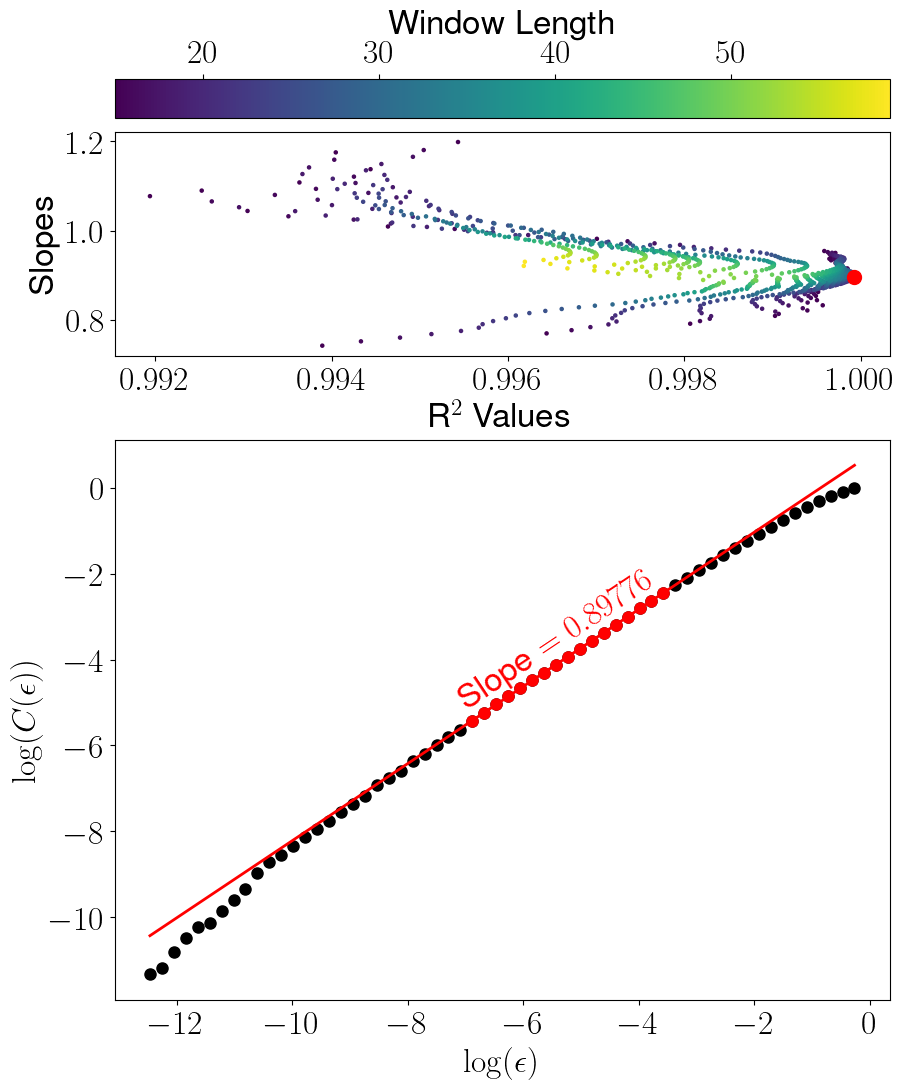

0.8977629822363167


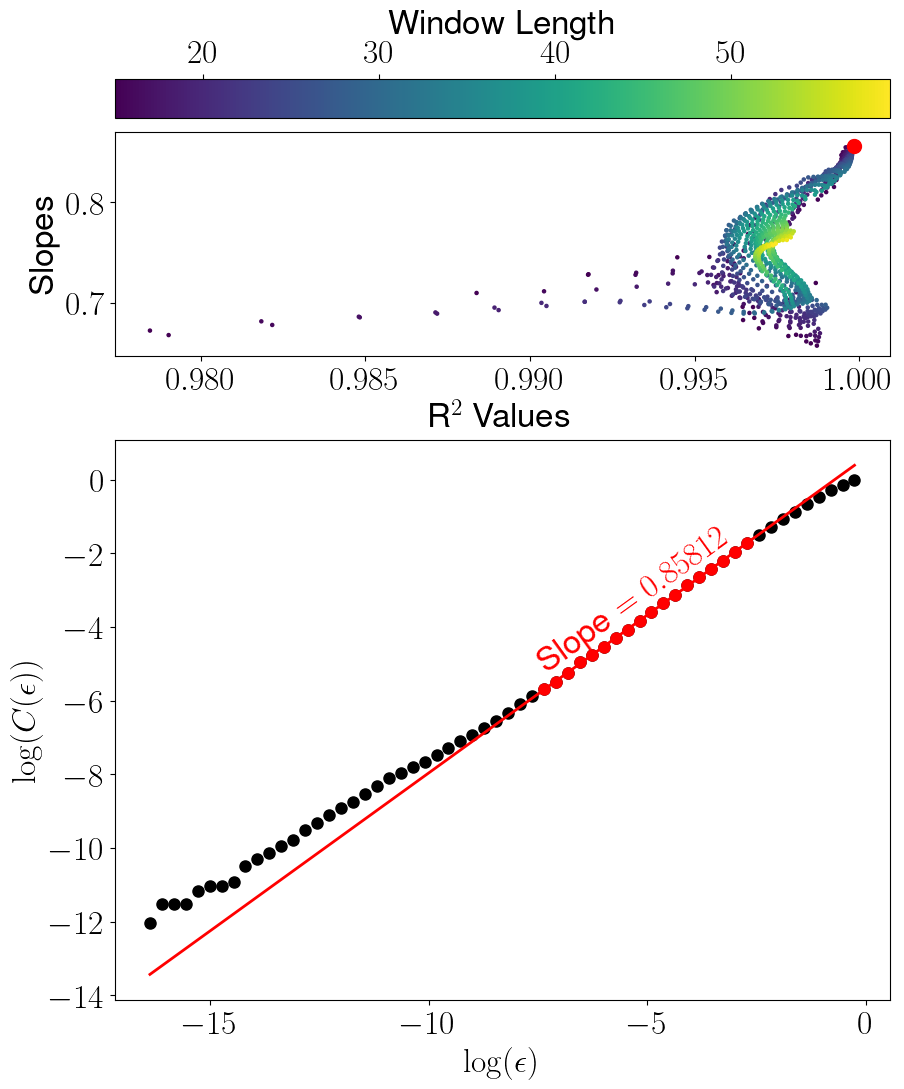

0.8581235518318369


In [87]:
i = 7
corrdim_test = correlation_dimension(test_results[i], num=60, lims=None, remove_pval=0.05, 
                                     mode='highest_r2',
                                     param=15, debug_plots=True, debug_data=False)
print(corrdim_test)

corrdim_pred_TreeDOX = correlation_dimension(pred_results[i], num=60, lims=None, remove_pval=0.05, 
                                             mode='highest_r2',
                                             param=15, debug_plots=True, debug_data=False)
print(corrdim_pred_TreeDOX)

# Recreating Bifurcation Diagram

In [ ]:
n_samples = 100
rs = np.linspace(2.75,4,n_samples)

# x0 = 0.25 # initial x value
n_train = 250
n_test = 250
rm_transient = 10
k = 20
xi = 1

results = np.zeros((n_samples,2))

for i, r in enumerate(tqdm(rs)):
    x = evolve(logistic,rm_transient + n_train + n_test + 2, np.random.uniform(low=0,high=1), r=r)
    x = x.reshape(-1,1)
    
    X_train, y_train = lead_data(x[rm_transient:rm_transient+n_train+1,:])
    X_test, y_test = lead_data(x[rm_transient+n_train+1:,:])
    
    features, labels = make_features_and_labels(X_train, k, xi=xi, stride=1, lead=1)
    
    FIs, time_elapsed = feature_selection(features, labels, n_estimators=10, max_depth=None, random_state=None,
                                          n_jobs=-1, n_samples=None, model_type='ETR', verbose=False)
    
    s = y_train[-k*xi:len(y_train)].T.flatten()
    y_pred_TreeDOX, model, time_elapsed = future_prediction(features, labels, FIs,
                                                            len(y_test), p=None, xi=xi,
                                                            n_estimators=25,
                                                            disp_progress=False,
                                                            desc='',
                                                            max_depth=None,
                                                            random_state=None,
                                                            n_jobs=-1,
                                                            min_samples_split=2,
                                                            min_samples_leaf=1,
                                                            ccp_alpha=0,
                                                            max_features=0.5,
                                                            n_samples=None,
                                                            model=None, s=s,
                                                            model_type='ETR',
                                                            verbose=False,
                                                            model_conversion=None,
                                                            device='cuda')
    
    results[i,:] = y_test[-1,0], y_pred_TreeDOX[-1,0]

In [7]:
import glob

r_chaos = 3.5699456

collect_results = False

if collect_results:
    fnames = [fname.split('\\')[-1] for fname in glob.glob(data_dir + 'logistic_bifurcation_predicted*') if 'final' not in fname]
    for i, fname in enumerate(fnames):
        if i == 0:
            with gzip.open(data_dir + fname, 'rb') as file:
                fixed_pt_pred = pkl.load(file)
        else:
            with gzip.open(data_dir + fname, 'rb') as file:
                fixed_pt_pred = np.vstack((fixed_pt_pred,pkl.load(file)))
                
    fixed_pt_pred = fixed_pt_pred[fixed_pt_pred[:, 0].argsort()]
    
    with gzip.open(data_dir + 'logistic_bifurcation_predicted_final.data', 'wb') as file:
        pkl.dump(fixed_pt_pred,file)
else:
    with gzip.open(data_dir + 'logistic_bifurcation_predicted_final.data', 'rb') as file:
            fixed_pt_pred = pkl.load(file)
            
with gzip.open(data_dir + 'logistic_bifurcation_true.data','rb') as file:
    r_vals = pkl.load(file) 
    fixed_pt_test = pkl.load(file)
    fixed_pt_test = np.vstack((r_vals, fixed_pt_test)).T

In [8]:
fixed_pt_pred.shape, fixed_pt_test.shape

((1000000, 2), (10000000, 2))

In [9]:
print(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos].shape, fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos].shape)
print(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos].shape, fixed_pt_test[fixed_pt_test[:,0]>=r_chaos].shape)

(40006, 2) (960001, 2)
(8924864, 2) (1075136, 2)


In [10]:
prop_nc_pred = fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos].shape[0]/fixed_pt_pred.shape[0]
prop_nc_test = fixed_pt_test[fixed_pt_test[:,0]<=r_chaos].shape[0]/fixed_pt_test.shape[0]
print(prop_nc_pred, prop_nc_test)

interp_r = np.linspace(np.min(fixed_pt_test[:,0]), r_chaos, round((1-prop_nc_test)*fixed_pt_test.shape[0]*prop_nc_pred/(1-prop_nc_pred)))
# interp_x = np.interp(interp_r, fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,0], fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,1])
f = sp.interpolate.interp1d(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,0], fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,1],
                            kind='nearest', bounds_error=False, fill_value='extrapolate')
interp_x = f(interp_r)

fixed_pt_test_interp = np.vstack((np.vstack((interp_r,interp_x)).T, fixed_pt_test[fixed_pt_test[:,0]>=r_chaos]))
fixed_pt_test_interp.shape, fixed_pt_test_interp[fixed_pt_test_interp[:,0]<=r_chaos].shape[0]/fixed_pt_test_interp.shape[0]

0.040006 0.8924864


((1119940, 2), 0.040005714591853134)

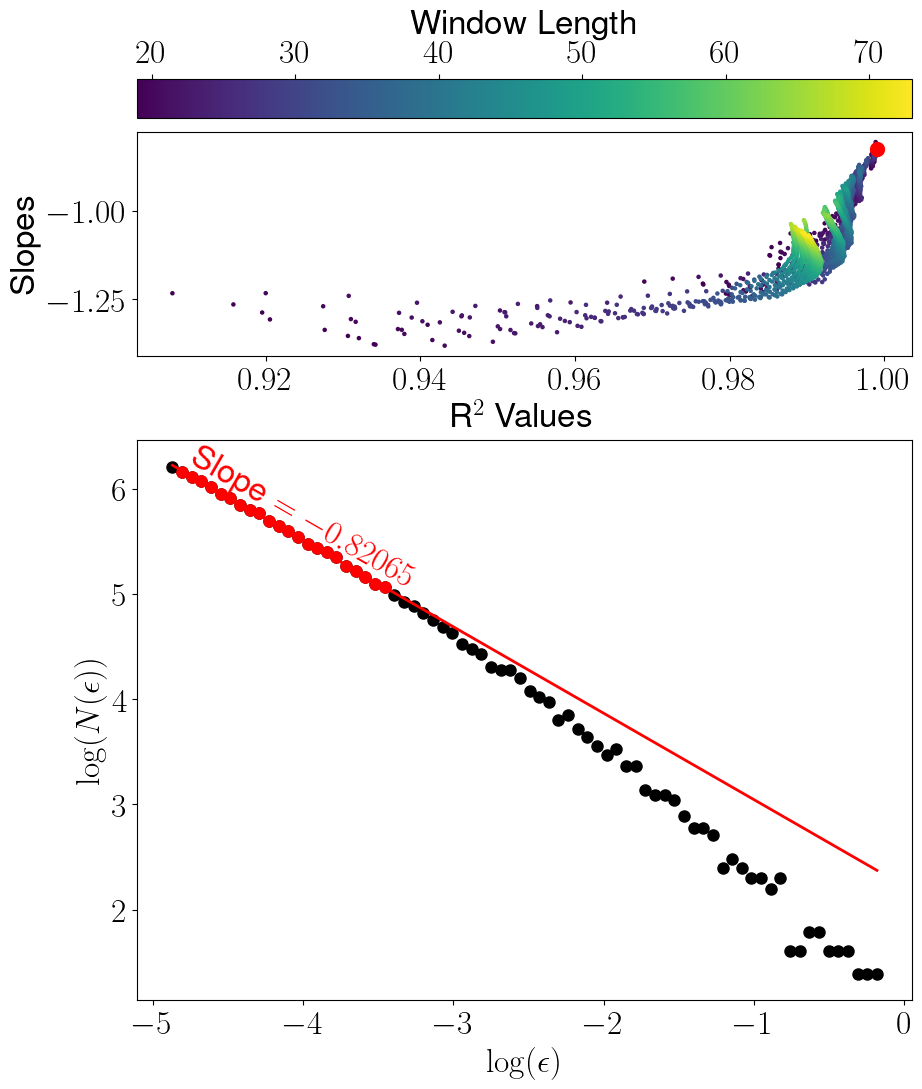

0.820646995265666


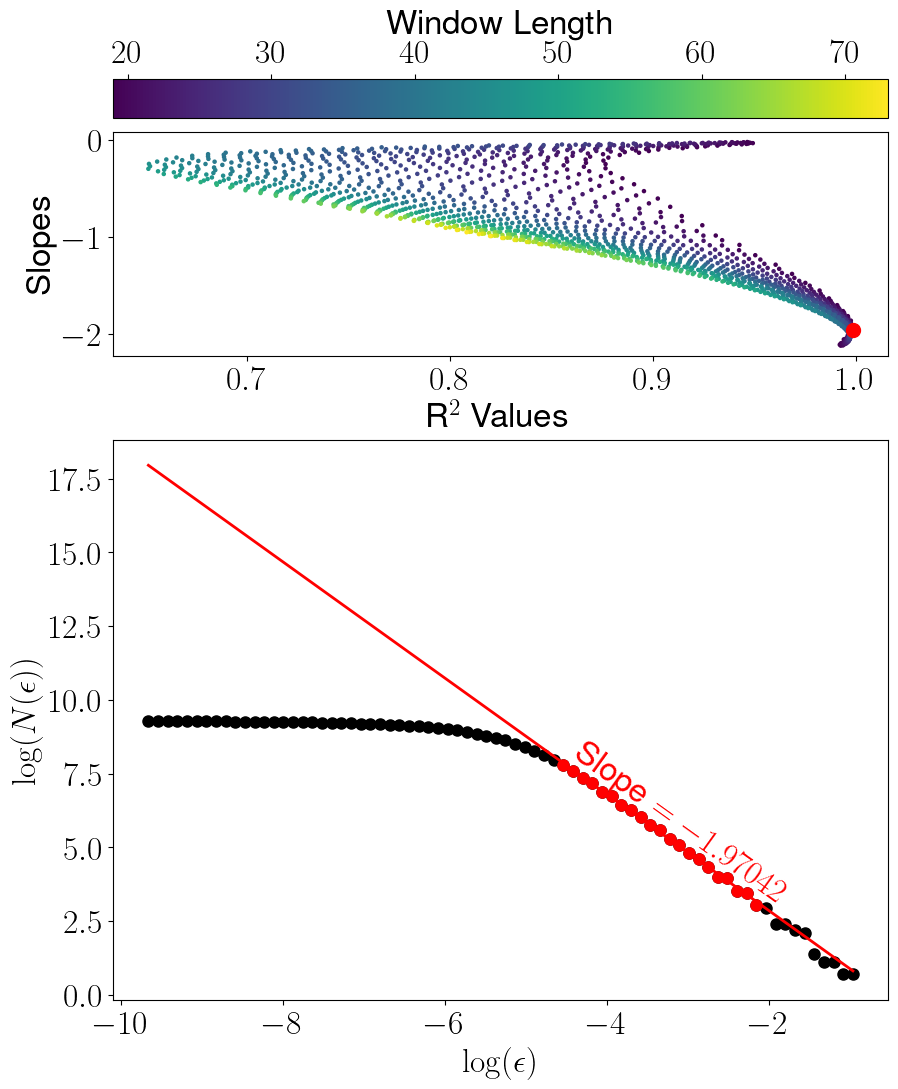

1.970421751911626


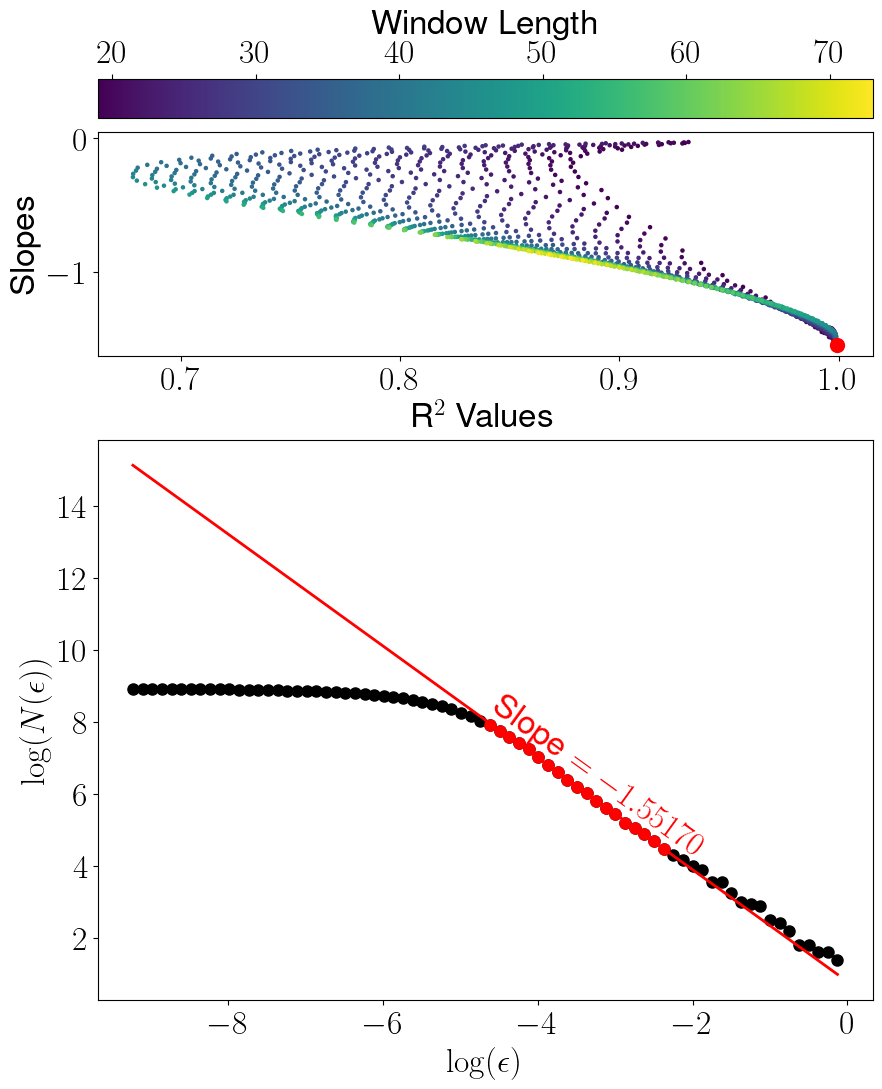

1.5517032129258244


In [43]:
hausdorff_dims_test = []

# pre-chaos
hausdorff_test_nc = hausdorff_dimension(fixed_pt_test_interp[fixed_pt_test_interp[:,0]<=r_chaos][::75], num=75, lims=None, remove_pval=0.05, 
                                        mode='highest_r2',
                                        param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_test.append(hausdorff_test_nc)
print(hausdorff_test_nc)

# post-chaos
hausdorff_test_c = hausdorff_dimension(fixed_pt_test[fixed_pt_test[:,0]>=r_chaos][::100], num=75, lims=None, remove_pval=0.05, 
                                       mode='highest_r2',
                                       param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_test.append(hausdorff_test_c)
print(hausdorff_test_c)

# all
hausdorff_test_all = hausdorff_dimension(fixed_pt_test_interp[::150], num=75, lims=None, remove_pval=0.05, 
                                         mode='highest_r2',
                                         param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_test.append(hausdorff_test_all)
print(hausdorff_test_all)

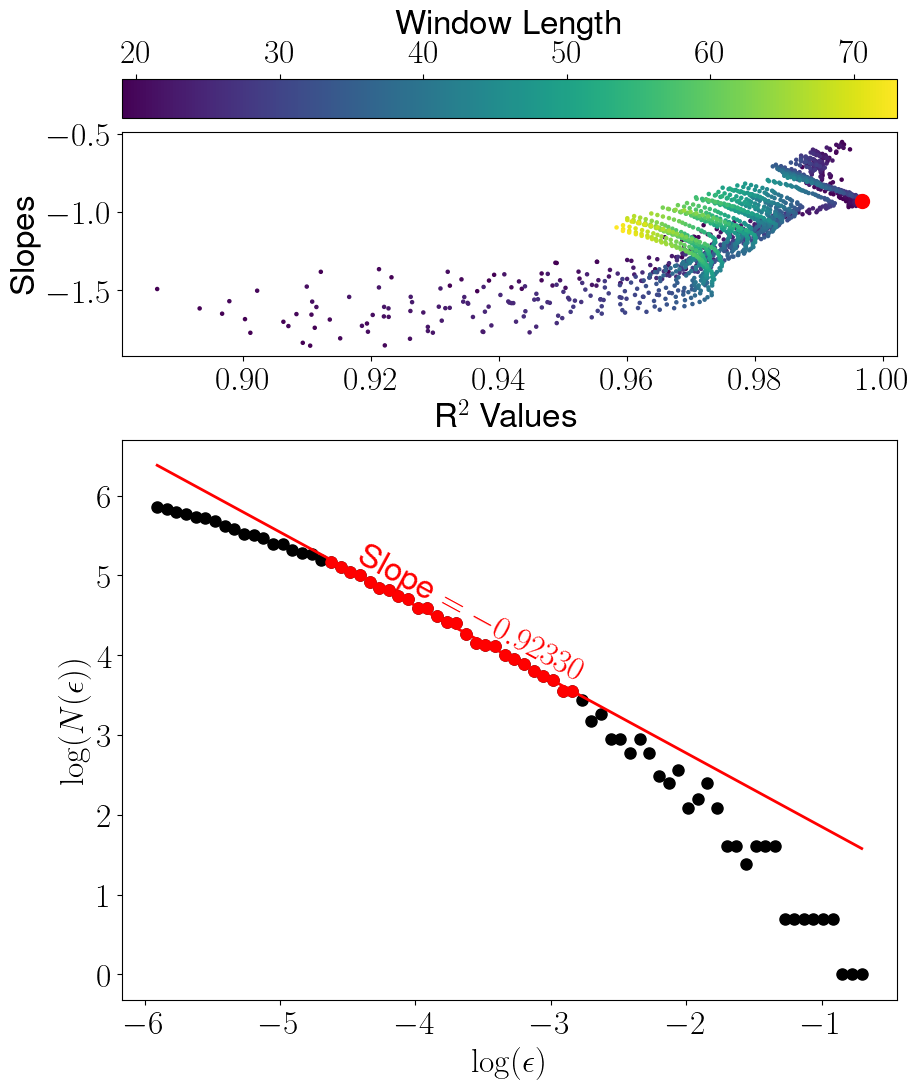

0.9233010799826352


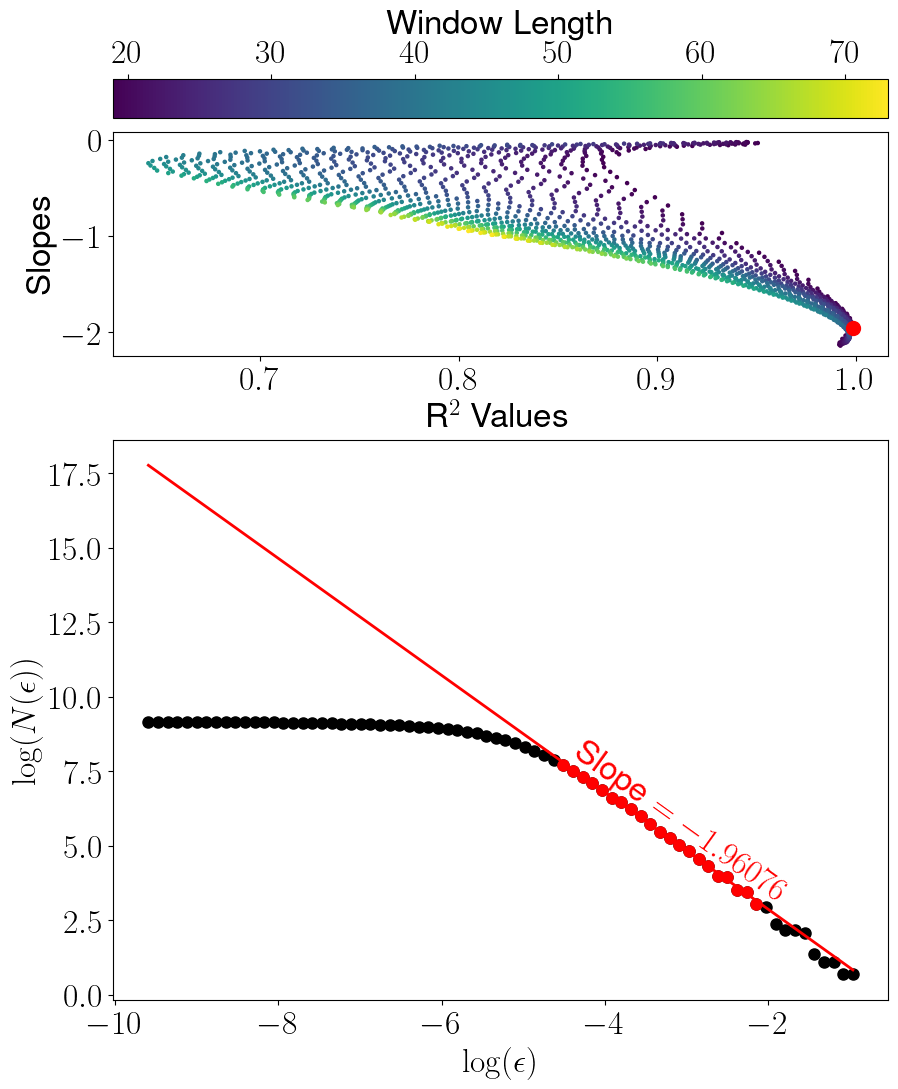

1.9607576418048613


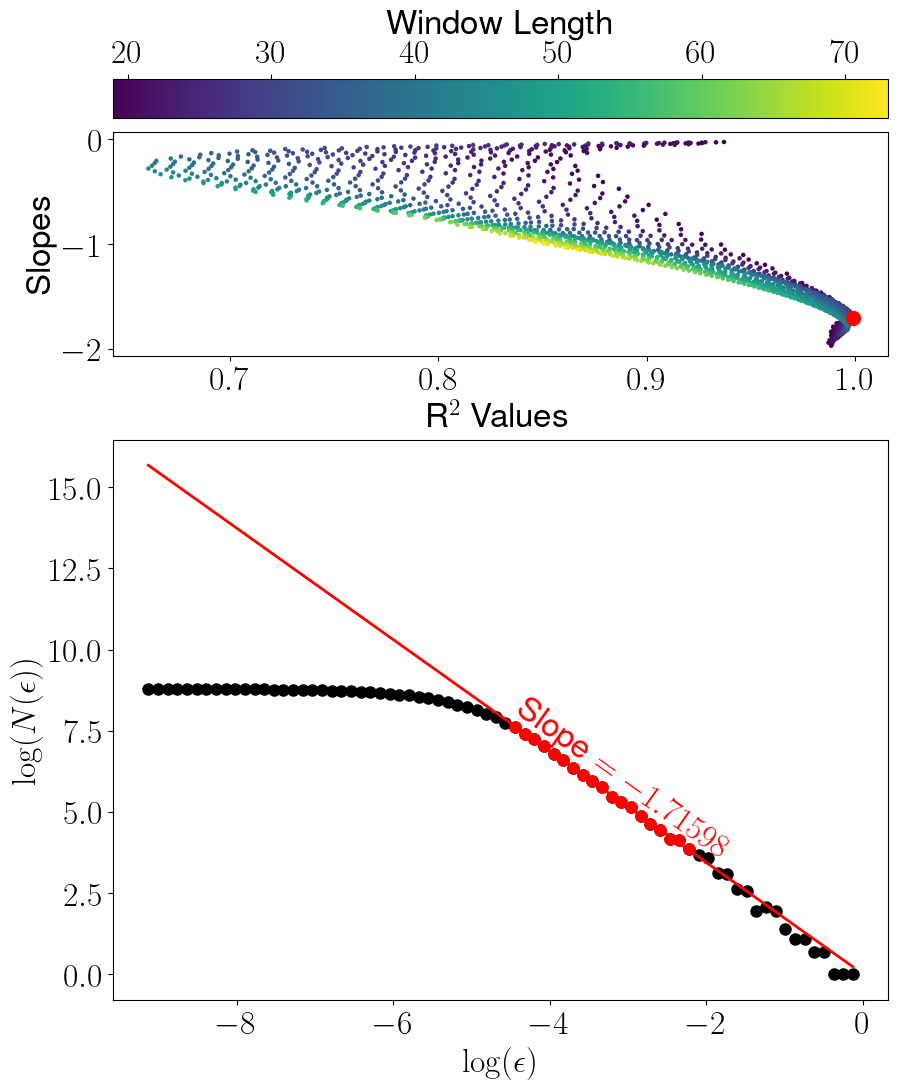

1.7159755473558937


In [44]:
hausdorff_dims_pred = []

# pre-chaos
hausdorff_pred_nc = hausdorff_dimension(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][::100], num=75, lims=None, remove_pval=0.05, 
                                        mode='highest_r2',
                                        param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_pred.append(hausdorff_pred_nc)
print(hausdorff_pred_nc)

# post-chaos
hausdorff_pred_c = hausdorff_dimension(fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][::100], num=75, lims=None, remove_pval=0.05, 
                                       mode='highest_r2',
                                       param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_pred.append(hausdorff_pred_c)
print(hausdorff_pred_c)

# all
hausdorff_pred_all = hausdorff_dimension(fixed_pt_pred[::150], num=75, lims=None, remove_pval=0.05, 
                                         mode='highest_r2',
                                         param=0.25, debug_plots=True, debug_data=False)
hausdorff_dims_pred.append(hausdorff_pred_all)
print(hausdorff_pred_all)

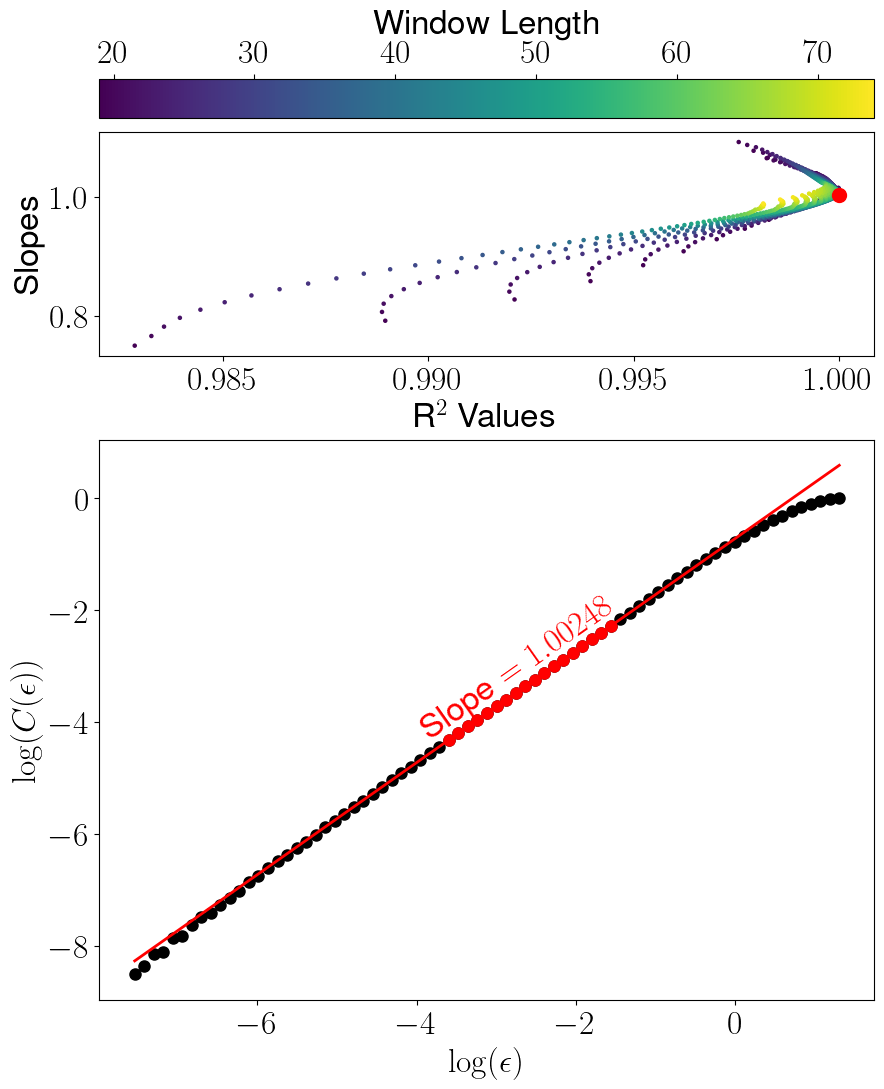

1.0024752752817347


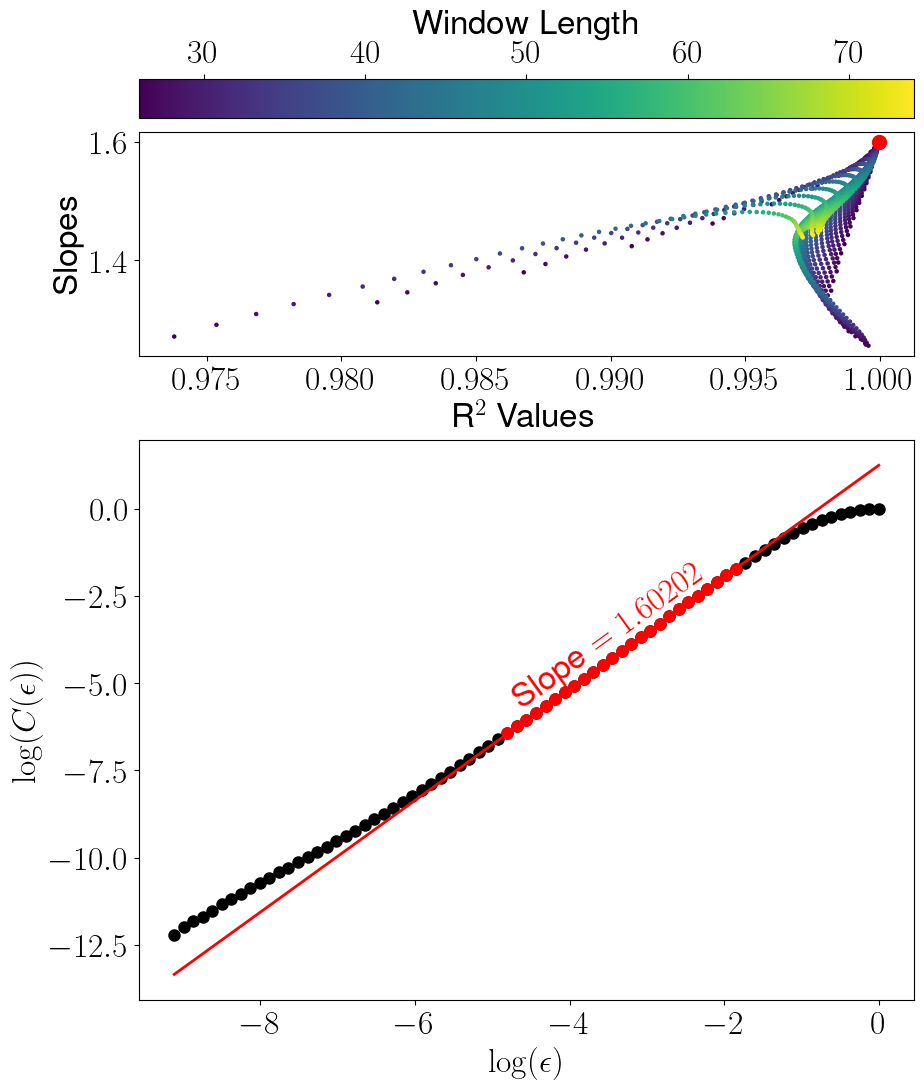

1.6020172696192598


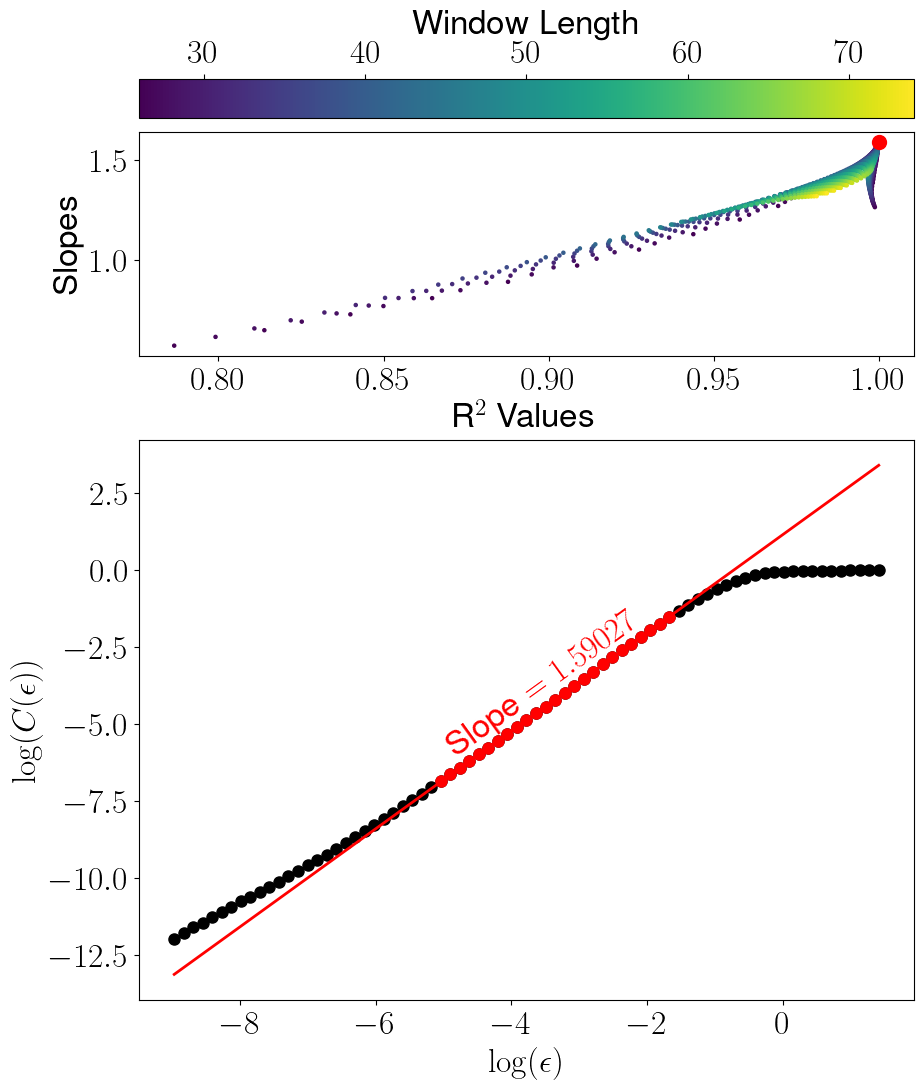

1.5902744057501366


In [11]:
correlation_dims_test = []

# pre-chaos
correlation_test_nc = correlation_dimension(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][::500], num=75, lims=None, remove_pval=0.1, 
                                        mode='highest_r2',
                                        param=0.25, debug_plots=True, debug_data=False)
# correlation_test_nc = correlation_dimension(fixed_pt_test_interp[fixed_pt_test_interp[:,0]<=r_chaos][::100], num=75, lims=None, remove_pval=0.1, 
#                                         mode='highest_r2',
#                                         param=0.25, debug_plots=True, debug_data=False)
correlation_dims_test.append(correlation_test_nc)
print(correlation_test_nc)

# post-chaos
correlation_test_c = correlation_dimension(fixed_pt_test[fixed_pt_test[:,0]>=r_chaos][::100], num=75, lims=None, remove_pval=0.1, 
                                       mode='highest_r2',
                                       param=0.35, debug_plots=True, debug_data=False)
correlation_dims_test.append(correlation_test_c)
print(correlation_test_c)

# all
correlation_test_all = correlation_dimension(fixed_pt_test_interp[::100], num=75, lims=None, remove_pval=0.1, 
                                         mode='highest_r2',
                                         param=0.35, debug_plots=True, debug_data=False)
correlation_dims_test.append(correlation_test_all)
print(correlation_test_all)

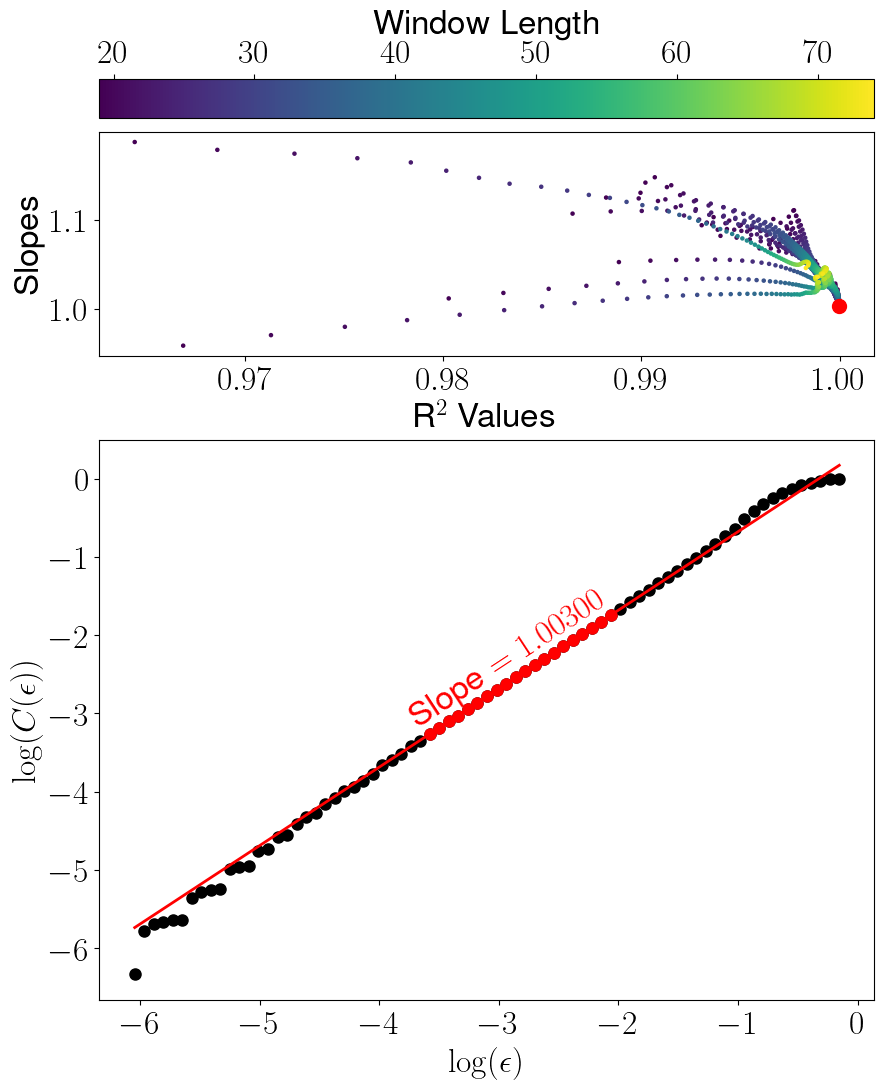

1.0030021584987543


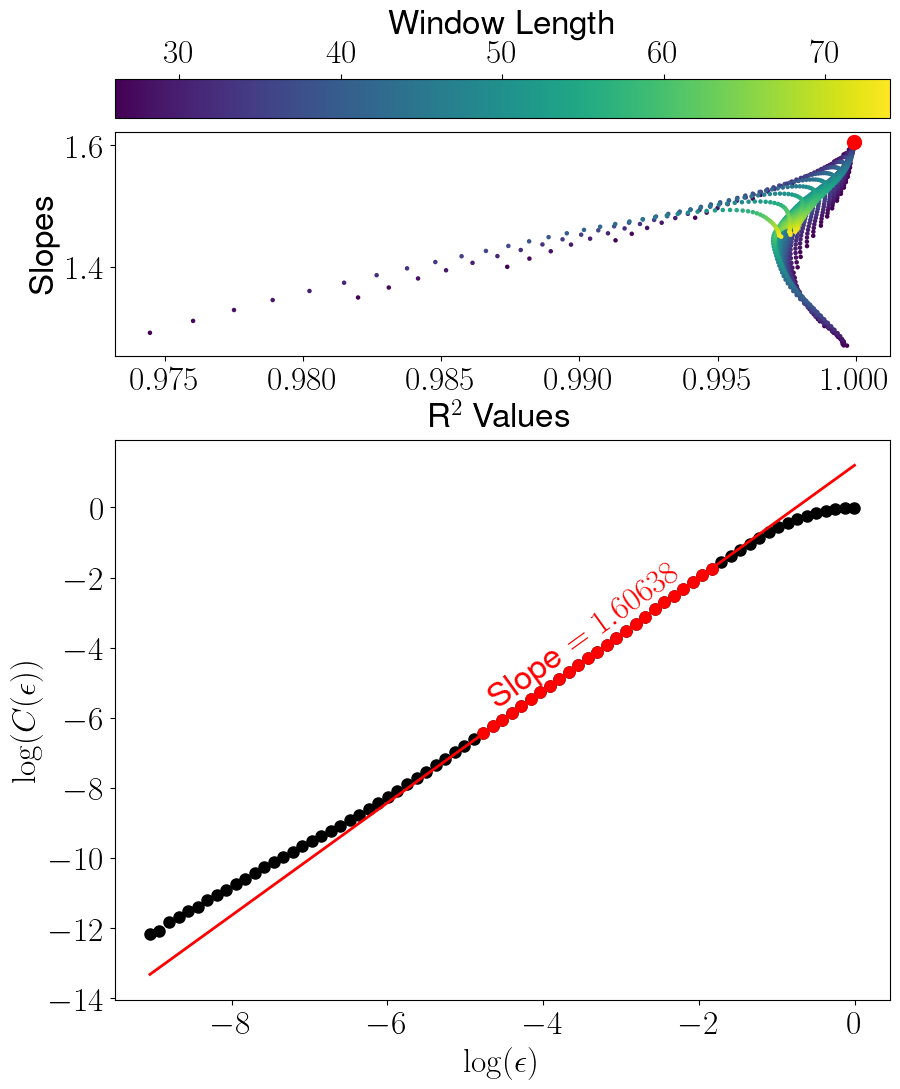

1.606382240127395


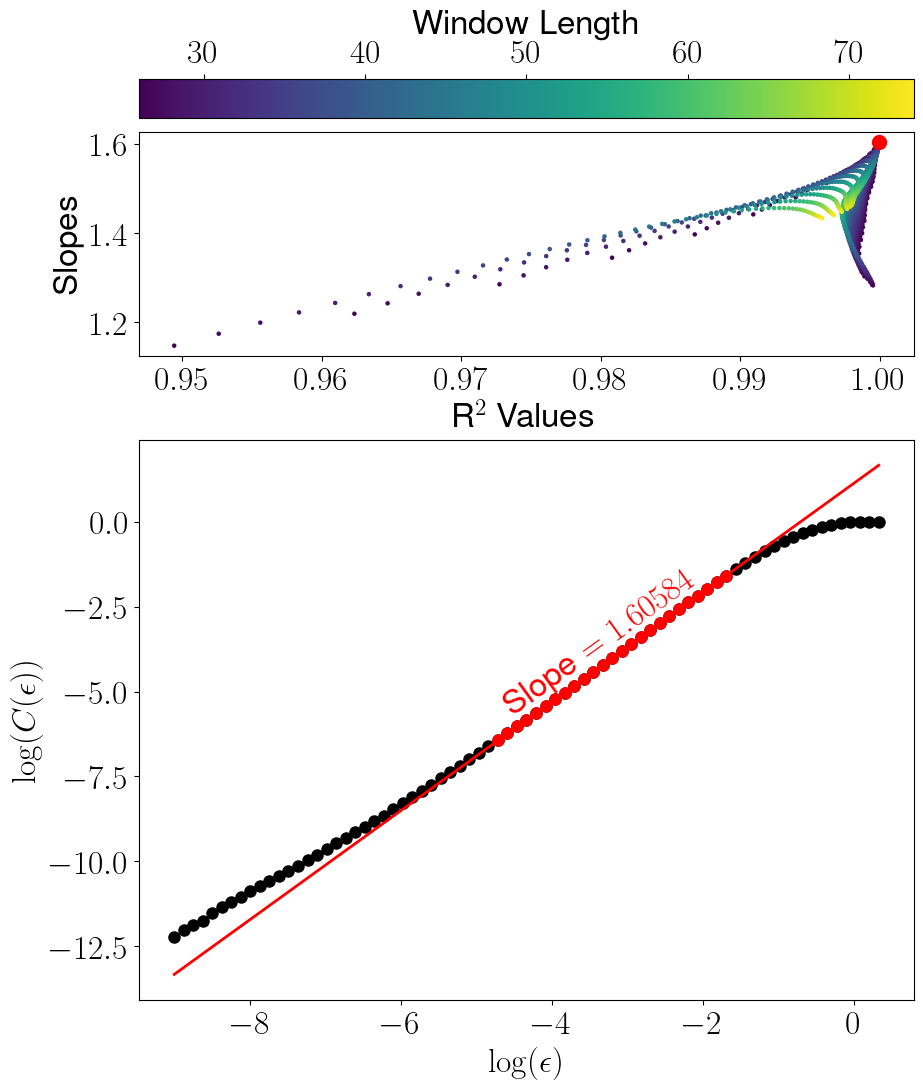

1.6058377939478699


In [18]:
correlation_dims_pred = []

# pre-chaos
correlation_pred_nc = correlation_dimension(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][::60], num=75, lims=None, remove_pval=0.1, 
                                        mode='highest_r2',
                                        param=0.25, debug_plots=True, debug_data=False)
correlation_dims_pred.append(correlation_pred_nc)
print(correlation_pred_nc)

# post-chaos
correlation_pred_c = correlation_dimension(fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][::100], num=75, lims=None, remove_pval=0.1, 
                                       mode='highest_r2',
                                       param=0.35, debug_plots=True, debug_data=False)
correlation_dims_pred.append(correlation_pred_c)
print(correlation_pred_c)

# all
correlation_pred_all = correlation_dimension(fixed_pt_pred[::100], num=75, lims=None, remove_pval=0.1, 
                                         mode='highest_r2',
                                         param=0.35, debug_plots=True, debug_data=False)
correlation_dims_pred.append(correlation_pred_all)
print(correlation_pred_all)

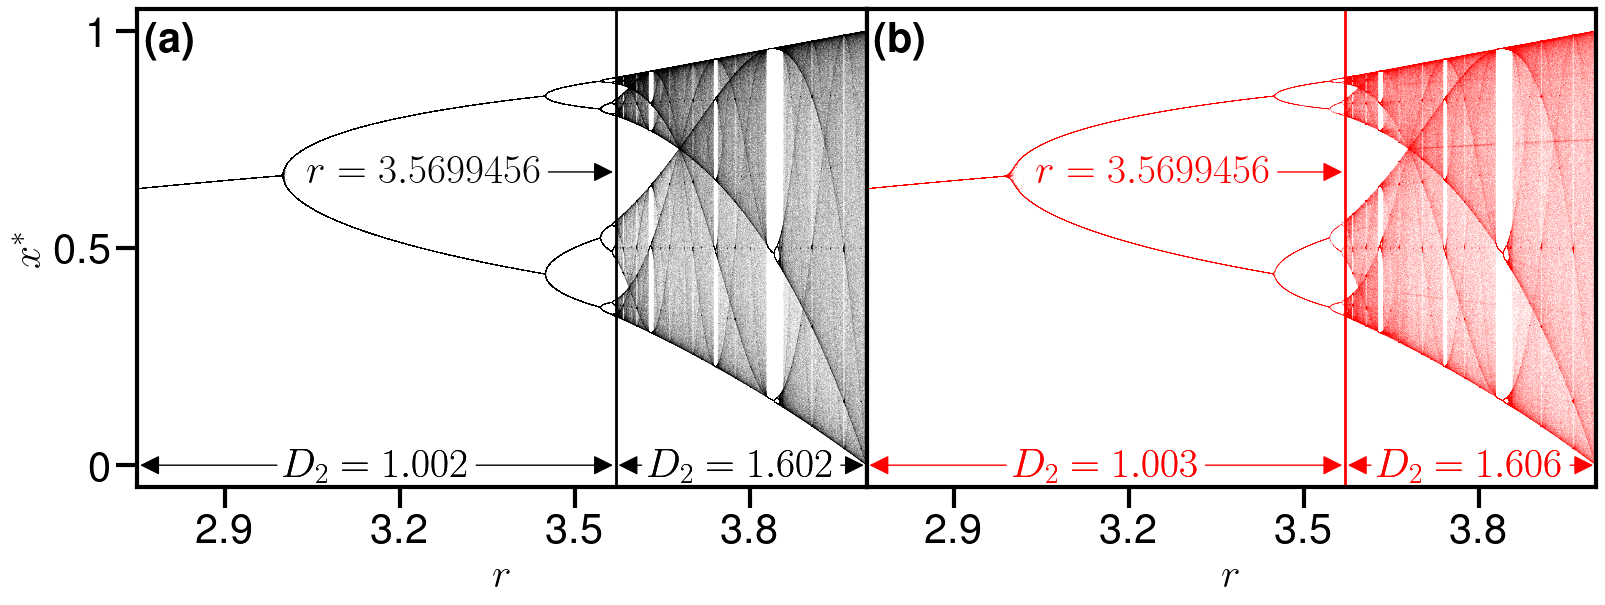

In [59]:
dimension = 'correlation' 
# dimension = 'hausdorff'
if dimension == 'correlation':
    dim_test, dim_pred = correlation_dims_test, correlation_dims_pred
    dim_label = 'D_2'
else:
    dim_test, dim_pred = hausdorff_dims_test, hausdorff_dims_pred
    dim_label = 'D_B'

fontsize=30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, axs = plt.subplots(1,2,figsize=(16, 6), sharey=True)
ax1, ax2 = axs

plot_stride = 1

ax1.scatter(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,0], fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][:,1],
            s=0.5, marker='.', facecolor='k', edgecolor='none', rasterized=True)
ax1.scatter(fixed_pt_test[fixed_pt_test[:,0]>=r_chaos][:,0], fixed_pt_test[fixed_pt_test[:,0]>=r_chaos][:,1],
            s=0.1, marker='.', facecolor='k', edgecolor='none', rasterized=True)

ax2.scatter(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][:,0], fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][:,1],
            s=0.5, marker='.', facecolor='r', edgecolor='none', rasterized=True)
ax2.scatter(fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][:,0], fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][:,1],
            s=0.1, marker='.', facecolor='r', edgecolor='none', rasterized=True)

# ax1.plot(fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][::plot_stride,0],
#          fixed_pt_test[fixed_pt_test[:,0]<=r_chaos][::plot_stride,1],'k.',ms=.03,zorder=10, rasterized=True)
# # ax1.plot(fixed_pt_test_interp[fixed_pt_test_interp[:,0]<=r_chaos][::plot_stride,0],
# #          fixed_pt_test_interp[fixed_pt_test_interp[:,0]<=r_chaos][::plot_stride,1],'k.',ms=.05,zorder=10, rasterized=True)
# ax1.plot(fixed_pt_test_interp[fixed_pt_test_interp[:,0]>=r_chaos][::plot_stride,0],
#          fixed_pt_test_interp[fixed_pt_test_interp[:,0]>=r_chaos][::plot_stride,1],'ko',ms=.005,mfc='r',zorder=10, rasterized=True)
# ax2.plot(fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][::plot_stride,0],
#          fixed_pt_pred[fixed_pt_pred[:,0]<=r_chaos][::plot_stride,1],'.',ms=.5,zorder=10, mfc='r', mec='none', rasterized=True)
# ax2.plot(fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][::plot_stride,0],
#          fixed_pt_pred[fixed_pt_pred[:,0]>=r_chaos][::plot_stride,1],'.',ms=.1,zorder=10, mfc='r', mec='none', rasterized=True)
# ax2.plot(fixed_pt_pred[::plot_stride,0],fixed_pt_pred[::plot_stride,1],'r.',ms=.02,zorder=10, rasterized=True)

ax1.set_ylabel(r'$x^*$',fontsize=fontsize)
# ax2.set_ylabel(r'$x^*$',fontsize=fontsize)
ax1.set_xlabel(r'$r$',fontsize=fontsize)
ax2.set_xlabel(r'$r$',fontsize=fontsize)

# plt.title('Logistic Map Bifurcation',fontsize=18)
xlim = [2.75,4]
ylim = [-0.05,1.05]
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()


ax1.plot([r_chaos,r_chaos],ylim,'k',zorder=0,lw=2)
# ax1.plot([xlim[0],xlim[0]],ylim,'k',zorder=0,lw=2)
# ax1.fill_between([xlim[0],r_chaos],ylim[0],ylim[1],color='r',alpha=0.1)
height = 0
ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[0]), xy=(xlim[0],height),
             xytext=(0.5*(xlim[0]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[0]), xy=(r_chaos,height),
             xytext=(0.5*(xlim[0]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[1]), xy=(r_chaos,height),
             xytext=(0.5*(xlim[1]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[1]), xy=(xlim[1],height),
             xytext=(0.5*(xlim[1]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
# height = 1
# ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[2]), xy=(xlim[0],height),
#              xytext=(0.5*(xlim[0]+xlim[1]),height), fontsize=fontsize,
#              va='center', ha='center',
#              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))
# ax1.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_test[2]), xy=(xlim[1],height),
#              xytext=(0.5*(xlim[0]+xlim[1]),height), fontsize=fontsize,
#              va='center', ha='center',
#              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', fc='k'))


ax2.plot([r_chaos,r_chaos],ylim,'r',zorder=0,lw=2)
# ax2.plot([xlim[0],xlim[0]],ylim,'k',zorder=0,lw=2)
# ax2.fill_between([xlim[0],r_chaos],ylim[0],ylim[1],color='r',alpha=0.1)
height = 0
ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[0]), xy=(xlim[0],height),
             xytext=(0.5*(xlim[0]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[0]), xy=(r_chaos,height),
             xytext=(0.5*(xlim[0]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[1]), xy=(r_chaos,height),
             xytext=(0.5*(xlim[1]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[1]), xy=(xlim[1],height),
             xytext=(0.5*(xlim[1]+r_chaos),height), fontsize=fontsize,
             va='center', ha='center', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
# height = 1
# ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[2]), xy=(xlim[0],height),
#              xytext=(0.5*(xlim[0]+xlim[1]),height), fontsize=fontsize,
#              va='center', ha='center', color='r',
#              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))
# ax2.annotate(r'${:} = {:.3f}$'.format(dim_label, dim_pred[2]), xy=(xlim[1],height),
#              xytext=(0.5*(xlim[0]+xlim[1]),height), fontsize=fontsize,
#              va='center', ha='center', color='r',
#              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))

ax1.set_yticks([0,0.5,1])
# ax2.set_yticks([0,0.5,1])
ax1.set_yticklabels([0,0.5,1])
# ax2.set_yticklabels([0,0.5,1])
xticks = [2.9,3.2,3.5,3.8]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks)

ax1.tick_params(bottom=True, top=False, left=True, right=False)
ax2.tick_params(bottom=True, top=False, left=False, right=False)


plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0)
fig.align_labels([axs])


plt.setp(ax1.spines.values(), linewidth=3, zorder=100)
plt.setp(ax2.spines.values(), linewidth=3, zorder=100)
ax1.tick_params(length=15,width=3)
ax2.tick_params(length=15,width=3)
ax1.annotate(r'\textbf{(a)}', xy=(0.01,0.975), ha='left', va='top', xycoords="axes fraction", fontsize=fontsize,
              bbox=dict(boxstyle='round,pad=0.1,rounding_size=0.5',fc='w',ec=None,lw=0,alpha=1))
ax2.annotate(r'\textbf{(b)}', xy=(0.01,0.975), ha='left', va='top', xycoords="axes fraction", fontsize=fontsize,
              bbox=dict(boxstyle='round,pad=0.1,rounding_size=0.5',fc='w',ec=None,lw=0,alpha=1))

ax1.annotate(fr'$r={r_chaos}$', xy=(r_chaos,0.675), ha='right', va='center', xycoords='data', fontsize=fontsize,
             xytext=(r_chaos-0.1*np.diff(ax1.get_xlim()),0.675), textcoords='data', color='k',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='k', fc='k'))
ax2.annotate(fr'$r={r_chaos}$', xy=(r_chaos,0.675), ha='right', va='center', xycoords='data', fontsize=fontsize,
             xytext=(r_chaos-0.1*np.diff(ax2.get_xlim()),0.675), textcoords='data', color='r',
             arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3', color='r', fc='r'))


title = 'Predicted Logistic Bifurcation'
# plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2, dpi=200)
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=500)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=400)
plt.show()
plt.close(fig)